# Toxic Comment Classification Challenge
- topics : NLP, binary classification, Data Visulization, Data Analysis
- 사용 모델 : ***Logistic Regression***
- score : 0.96963 (private)
- kaggle link : https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge

##### 데이터 세트
- Train data : 159571
- Test data :  153164

- **missing value**: 없음

#### 데이터 세부 사항 
- 'id' : 각 데이터 마다 unique하게 부여
- 'comment_text' : 예측에 사용되는 텍스트 -> '전처리, 토큰화, 분류' 과정  

- ***target columns*** : 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
    - 각 칼럼 마다 0, 1로 예측하는 이진 분류 
    - 즉 이진 분류를 6번 진행
- ***전처리 과정 결정***
    - 약어 치환 : 줄임말, 약어 치환
    - 불용어 제거 : Countvectorizer 를 이용한 불용어 선정 + nltk stopwords list 이용
    - 특수 문자 제거 : 영어를 제외한 문자 제거 
    - 반복 단어 제거 : 반복 단어 제거 전/후 모델의 성능 비교를 통해 제거 여부 결정 (제거하지 않음)
- ***Feature Engineering***
    [to-do]
    - 문장의 길이, 단어의 개수를 feature로 넣으면 영향을 주는 지 
    - 각 target을 classification할 때, 순차적으로 진행해서 이전의 예측을 다음 target의 예측에 사용할 수 있는지 

- **Model**
    - model1 : Logistic regression
    - model2[to-do] : deep learning model...

In [163]:
import re
import numpy as np
import pandas as pd

# visualization
import missingno as msno # missing value check
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier


# evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings(action='ignore') 

# 1. Data Load

In [164]:
import os
file_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_list.append(os.path.join(dirname, filename))
        
import zipfile
for i in range(len(file_list)):
    with zipfile.ZipFile(file_list[i],"r") as z:
        z.extractall(".")
        
# load data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# submission example
submission = pd.read_csv('./sample_submission.csv')
test_labels = pd.read_csv('./test_labels.csv')

print("train data length: ", len(train))
print("test data length: ", len(test))

train data length:  159571
test data length:  153164


In [165]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [166]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [167]:
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

In [168]:
# Check missing value
print(train.isnull().value_counts())
print('-'*30)
print(train.isnull().sum())

id     comment_text  toxic  severe_toxic  obscene  threat  insult  identity_hate
False  False         False  False         False    False   False   False            159571
dtype: int64
------------------------------
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [169]:
# data size
print('size of train : {}'.format(len(train)))
print('size of test : {}'.format(len(test)))
print('-'*20)
print(train[target_cols].sum().sort_values(ascending=False))

size of train : 159571
size of test : 153164
--------------------
toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


# EDA
- 텍스트 전처리 
- 약어, 불용어 제거 
- 반복 제거 여부 결정 

In [170]:
train['sum_harmful'] = 0
for col in target_cols:
    train['sum_harmful'] += train[col]
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_harmful
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [171]:
# 텍스트 전처리 전,텍스트 길이 분포 확인 
train['len_of_text'] = train['comment_text'].apply(len)

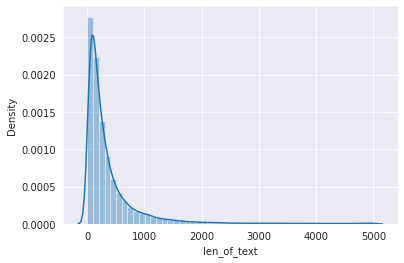

In [172]:
# 텍스트 길이 분포 시각화
sns.set_style("darkgrid")
sns.distplot(train['len_of_text'],kde=True)
plt.show()

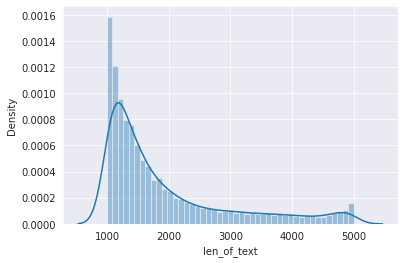

In [173]:
# 대부분이 1000 이하의 텍스트 길이 -> 1000 이상을 한 번 보자
x = train.loc[train['len_of_text'] > 1000,'len_of_text']
sns.distplot(x,kde=True)
plt.show()

0    12521
1      419
3      146
2      128
4      121
5       23
6        2
Name: sum_harmful, dtype: int64


<AxesSubplot:xlabel='sum_harmful', ylabel='count'>

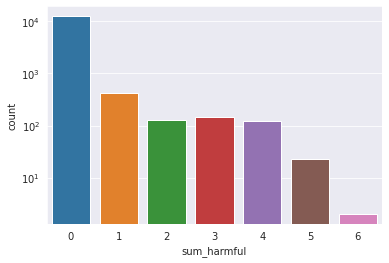

In [174]:
# 길이가 1000이상인 데이터의 target_cols이 1로 분류된 것의 개수의 합 
print(train.loc[train['len_of_text'] > 1000,'sum_harmful'].value_counts())

plt.yscale('log')
display(sns.countplot(train.loc[train['len_of_text'] > 1000,'sum_harmful']))

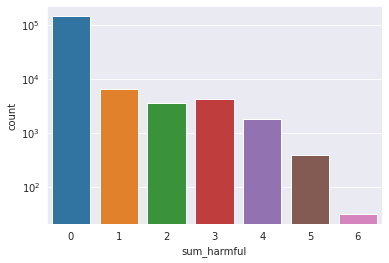

In [175]:
# 1000이상도 기존의 데이터 분포와 비슷해 보인다 -> 이상치 처리 하지 않음 
plt.yscale('log')
sns.countplot(train['sum_harmful'])
plt.show()

In [176]:
train['sum_harmful'].value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: sum_harmful, dtype: int64

In [177]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_harmful,len_of_text
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.219952,394.073221
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.748260,590.720282
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,96.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,435.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5000.000000


# 1. 텍스트 전처리 - 줄임말 바꾸기

In [178]:
# is, has, have 등 동사 줄임 처리
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [179]:
train['preprocess_text'] = train['comment_text'].apply(clean_text)
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_harmful,len_of_text,preprocess_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112,d aww he matches this background colour i am s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233,hey man i am really not trying to edit war it ...


# 2. 텍스트 전처리 - 불용어 제거
- 불용어 리스트 만들기 - Countvectorizer 사용
- 불용어 제거 - 기존의 nltk에서 제공하는 stopwords와 위에서 생성한 불용어 리스트를 함께 사용

In [180]:
# 전체 데이터에 대해 Countvectorizer
cv = CountVectorizer() # 만약 n-gram으로 설정시 안에 (2-gram까지하는 경우)ngram_range = (1, 3) 를 설정
documents = train.comment_text.tolist()
documents = [' '.join(documents)] 

X = cv.fit_transform(documents).toarray()
freqs = X.transpose().flatten() # 1차원으로, 어레이로 되어있는 인코딩 벡터들을 1차원으로 펴줌
words = cv.get_feature_names() # Array mapping from feature integer indices to feature name.

df_word = pd.DataFrame({'word': words, 'freq': freqs})
df_word = df_word.sort_values(by='freq', ascending=False)

df_word = df_word.reset_index().drop(['index'],axis=1)
df_word[:10]

,word,freq
0,the,496796
1,to,297408
2,of,224547
3,and,224092
4,you,218308
5,is,176405
6,that,160867
7,it,148644
8,in,145477
9,for,102723


In [181]:
stopwords_list = df_word.word.tolist()[:70]
print('학습 데이터로 만든 불용어 개수 : ',len(stopwords_list))
print(stopwords_list[:10],'...')

# nltk의 stopwords 사용
from nltk.corpus import stopwords
stopwords_list+=stopwords.words('english')
stopwords = set(stopwords_list)
print(' ')
print("최종 stopwords 개수 :", len(stopwords))

학습 데이터로 만든 불용어 개수 :  70
['the', 'to', 'of', 'and', 'you', 'is', 'that', 'it', 'in', 'for'] ...
 
최종 stopwords 개수 : 192


In [182]:
from nltk.tokenize import word_tokenize

# nltk의 토크나이저를 이용해서 토큰화한 뒤 불용어 제거, 길이가 2이하인 토큰 제거
def remove_stopwords(text):
    stopwords_list = stopwords
    word_tokens = word_tokenize(text)
    result = []
    for w in word_tokens:
        if len(w)>2 and w not in stopwords_list:
            result.append(w)
    return ' '.join(result)

# 영어만 제외하고 제거, 소문자화
def remove_special(text, lower=True):
    if lower:
        text = text.lower()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = " ".join(
        text.split()
    )
    return text

def remove_repeat(text, repeat=1):
    text = text.split(' ')
    result = []
    for word in text:
        if result.count(word)<repeat:
            result.append(word)
    return ' '.join(result)

In [183]:
train['preprocess_text'] = train['preprocess_text'].apply(remove_special)
train['preprocess_text'] = train['preprocess_text'].apply(remove_stopwords)

In [184]:
test['preprocess_text'] = test['comment_text'].apply(clean_text)
test['preprocess_text'] = test['preprocess_text'].apply(remove_special)
test['preprocess_text'] = test['preprocess_text'].apply(remove_stopwords)

# 3. 텍스트 전처리 - 반복 제거 여부 결정

count    159571.000000
mean         31.193506
std          49.602668
min           1.000000
25%           7.000000
50%          16.000000
75%          34.000000
max        1250.000000
Name: preprocess_text, dtype: float64


<AxesSubplot:xlabel='preprocess_text', ylabel='Density'>

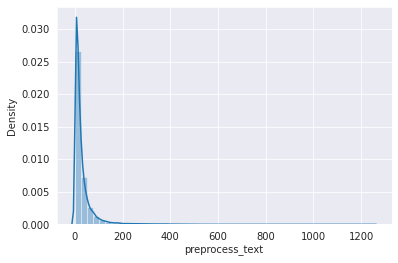

In [185]:
# 단어 개수를 알아보자
def num_of_word(text):
    return len(text.split(' '))

tmp = train['preprocess_text'].apply(num_of_word)
print(tmp.describe())
sns.distplot(tmp)

### word number
- 단어 개수가 75%가 34개 이하 
- 그런데 max = 1250으로 매우 크다 
- 500개 이상 , 1000개 이상인 데이터를 봐보자 

In [186]:
train['num_of_word'] = train['preprocess_text'].apply(num_of_word)
display(train[(train['num_of_word'] > 500)&(train['num_of_word'] < 1000)].head(3))
display(train[train['num_of_word'] > 1000])

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_harmful,len_of_text,preprocess_text,num_of_word
2420,067c5e814e88a56b,FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT ...,1,1,1,0,1,0,4,4999,fuck useless bot fuck useless bot fuck useless...,652
4174,0b2055f13934a41e,ii CAN STILL POST WITH THIS COMPUTER...I SAID ...,1,0,1,0,1,0,3,5000,still post computer said block come fuck arres...,520
4712,0c7c341727488579,do go fuck off bastard\nDo Yyou Have a life?\n...,1,1,1,1,1,0,5,4969,fuck bastard yyou life fuck bastard yank cock ...,700


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_harmful,len_of_text,preprocess_text,num_of_word
6572,118e2e7cd2b30188,Sex sex sex sex Sex sex sex sexSex sex sex sex...,1,0,0,0,0,0,1,4999,sex sex sex sex sex sex sex sexsex sex sex sex...,1001
32143,5572234220e43ea2,PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PI...,1,0,0,0,0,0,1,4999,pig pig pig pig pig pig pig pig pig pig pig pi...,1250
32400,56311e1c0b2cbb52,THAT WAS REALLY MILLESECONDS WASNT IT BITCH \n...,1,0,1,0,1,1,4,4981,really milleseconds wasnt bitch fat jew fat je...,1235
76598,cd135d9358a9e9ea,DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FA...,1,0,0,0,0,0,1,4999,die fag die fag die fag die fag die fag die fa...,1250
150039,65d66bf057752682,LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LO...,0,0,0,0,0,0,0,4999,lol lol lol lol lol lol lol lol lol lol lol lo...,1250
153353,9bb20c51c9fec236,FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JE...,1,0,0,0,1,1,3,4999,fat jew fat jew fat jew fat jew fat jew fat je...,1247


 단어의 개수가 큰 경우에
 중복되는 단어가 많은 경우 유해한 경향이 있음 
 --> 이걸 없애면 모델이 이런 경향을 적게 캐치할까?
- 제거 전/후 모델 성능 비교 실험 진행

In [187]:
# 중복 제거 여부 성능 비교를 위해서 칼럼을 따로 만들어서 저장 
train['remove_repeat'] = train['preprocess_text'].apply(remove_repeat)
test['remove_repeat'] = test['preprocess_text'].apply(remove_repeat)

display(train.head(3))
display(test.head(3))

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_harmful,len_of_text,preprocess_text,num_of_word,remove_repeat
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264,explanation edits made username hardcore metal...,20,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112,aww matches background colour seemingly stuck ...,9,aww matches background colour seemingly stuck ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233,hey man really trying edit war guy constantly ...,19,hey man really trying edit war guy constantly ...


,id,comment_text,preprocess_text,remove_repeat
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,bitch rule succesful ever whats hating sad mof...,bitch rule succesful ever whats hating sad mof...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,rfc title fine imo,rfc title fine imo
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sources zawe ashton lapland,sources zawe ashton lapland


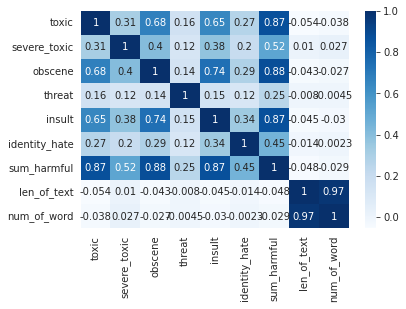

In [188]:
# column들의 상관관계 확인 - heatmap 
corr_matrix = train.corr()
sns.heatmap(corr_matrix, cmap='Blues',annot=True)
plt.show()

# TFIDF vectorization
- min_df : 벡터화하는 최소 df값(이 값보다 작으면 벡터화하지 않음)
- analyzer : 
    - 'word': 단위가 단어
    - 'char': 단위가 문자 
- sublinear_tf : 문서의 단어 빈도 수(TF, term frequency)에 대한 스무딩 여부.
- ngram_range : 빈도를 계산할 기본 단위인 n-gram의 범위 설정
- max_features : 각 벡터의 최대 길이
    - 이 값을 설정하지 않으면 featrue가 많은 경우에(단어/토큰 많은 경우) 매우 sparse한 matrix가 생성

### 1. 반복제거 전 텍스트로 학습

In [189]:
preprocess_text = train.preprocess_text

vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(preprocess_text)
y = train[target_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

print('X_train len: ', X_train.shape[0])
print('X_valid len:  ',  X_valid.shape[0])

X_train len:  127656
X_valid len:   31915


In [190]:
from collections import defaultdict
accuracy_data = defaultdict(list)
for col in target_cols:
    print(' ')
    print('----prediction of {} column----'.format(col))
    print(' ')
    y = y_train[col]
    model = LogisticRegression()
    model.fit(X_train,y)
    y_pred = model.predict(X_valid)
    print('Testing accuracy is {}'.format(round(accuracy_score(y_valid[col], y_pred),5)))
    accuracy_data[col].append(round(accuracy_score(y_valid[col], y_pred),5))

 
----prediction of toxic column----
 
Testing accuracy is 0.9571
 
----prediction of severe_toxic column----
 
Testing accuracy is 0.99
 
----prediction of obscene column----
 
Testing accuracy is 0.97735
 
----prediction of threat column----
 
Testing accuracy is 0.99727
 
----prediction of insult column----
 
Testing accuracy is 0.97026
 
----prediction of identity_hate column----
 
Testing accuracy is 0.99201


### 2. 반복 단어 제거 텍스트로 학습

In [191]:
remove_repeat_text = train.remove_repeat

vectorizer2 = TfidfVectorizer(max_features=5000)

X2 = vectorizer2.fit_transform(remove_repeat_text)
y = train[target_cols]

X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2, y, test_size=0.2, random_state=0)

print('X_train len: ', X_train2.shape[0])
print('X_valid len:  ',  X_valid2.shape[0])

X_train len:  127656
X_valid len:   31915


In [192]:
# model2
for col in target_cols:
    print(' ')
    print('----prediction of {} column----'.format(col))
    print(' ')
    y = y_train2[col]
    model2 = LogisticRegression()
    model2.fit(X_train2,y)
    y_pred2 = model.predict(X_valid2)
    print('Testing accuracy is {}'.format(round(accuracy_score(y_valid2[col], y_pred2),5)))
    accuracy_data[col].append(round(accuracy_score(y_valid2[col], y_pred2),5))

 
----prediction of toxic column----
 
Testing accuracy is 0.90243
 
----prediction of severe_toxic column----
 
Testing accuracy is 0.98916
 
----prediction of obscene column----
 
Testing accuracy is 0.94633
 
----prediction of threat column----
 
Testing accuracy is 0.99662
 
----prediction of insult column----
 
Testing accuracy is 0.94952
 
----prediction of identity_hate column----
 
Testing accuracy is 0.99013


In [193]:
tmp = pd.DataFrame(accuracy_data, index=['allow_rep','remove_rep'])
tmp

,toxic,severe_toxic,obscene,threat,insult,identity_hate
allow_rep,0.95710,0.99000,0.97735,0.99727,0.97026,0.99201
remove_rep,0.90243,0.98916,0.94633,0.99662,0.94952,0.99013


### 최종 전처리 결정
- 결론 전처리 과정에서 반복을 없애는 건, 차원을 줄이는데는 효과적이지만 유해한 텍스트의 경향성을 없앨 수 있으므로 반복 제거는 하지 않는다. 
- 전처리는 영어를 제외한 특수 문자 제거, 소문자화, 불용어 제거만 진행 

In [194]:
pre_test = test.preprocess_text
X_test = vectorizer.transform(pre_test)

## submission 파일 제출

In [195]:
# train set 전체 활용
submission_prediction = submission.copy()
preprocess_text = train.preprocess_text

vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(preprocess_text)
y = train[target_cols]

for col in target_cols:
    print(' ')
    print('----prediction of {} column----'.format(col))
    y_train = y[col]
    model = LogisticRegression()
    model.fit(X,y_train)
    test_y_prob = model.predict_proba(X_test)[:,1]
    submission_prediction[col] = test_y_prob

 
----prediction of toxic column----
 
----prediction of severe_toxic column----
 
----prediction of obscene column----
 
----prediction of threat column----
 
----prediction of insult column----
 
----prediction of identity_hate column----


In [196]:
DATA_PATH = './'
submission_prediction.to_csv(DATA_PATH+'submission.csv',index=False)

### [To-do]

### 3. 정수 인코딩 - 나중에 딥러닝시에 사용할 정수인코딩
- 보카 생성
- max_len로 시퀀스 길이 설정 -> 패딩 0 (뒤에 추가)

#### 파일 
- word_vocab: 전처리한 텍스트로 만든 voca, (key = word, value = integer index)

In [197]:
# 케라스를 이용한 보카 만들기
from tensorflow.keras.preprocessing.text import Tokenizer

preprocess_texts = []
for text in train['preprocess_text']:
    preprocess_texts.append(text.split(' '))
    
print(preprocess_texts[:2])

[['explanation', 'edits', 'made', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'vandalisms', 'closure', 'gas', 'voted', 'new', 'york', 'dolls', 'fac', 'remove', 'template', 'since', 'retired'], ['aww', 'matches', 'background', 'colour', 'seemingly', 'stuck', 'thanks', 'january', 'utc']]


In [198]:
tokenizer = Tokenizer(oov_token = 'OOV') # OOV 단어는 1로 인덱스

# fit_on_texts(corpus) : corpus의 단어들을 빈도수를 기준으로 단어 집합 생성
# (높은순->낮은순으로 인덱스 부여)
tokenizer.fit_on_texts(preprocess_texts)

# padding voca 생성 -> 0 index
word_vocab = tokenizer.word_index
word_vocab["<PAD>"] = 0

print('총 voca 개수: ', len(word_vocab))

총 voca 개수:  168472


In [199]:
# preprocess_texts를 정수 인코딩 
encoded = tokenizer.texts_to_sequences(preprocess_texts)

# 정수 인코딩벡터 길이 맞춰주기 
MAX_SEQ_LEN = max(len(item) for item in encoded)

# 길이를 토큰 시퀀스의 최대 길이로 맞춰주고 뒤에 0으로 padding
print('padding len: ', MAX_SEQ_LEN)
padded = pad_sequences(encoded,maxlen=MAX_SEQ_LEN ,padding='post')
print('train data -> padding shape: {}'.format(padded.shape))

padding len:  1250
train data -> padding shape: (159571, 1250)


#### 훈련데이터 저장 
- 전처리한 학습 데이터 저장 -> preprocess_train.csv
- 정수 벡터화한 시퀀스 저장 -> encoding_train.npy
- 라벨 저장 -> label_train.csv

In [200]:
tmp = train[['id','preprocess_text']]

# save preprocess tests
tmp.to_csv(DATA_PATH+'/preprocess_train.csv')

# save encoding data
np.save(open(DATA_PATH + 'encoding_train.npy', 'wb'), padded)

# save preprocess text test data
y = train[target_cols]
y.to_csv(DATA_PATH+'label_train.csv',index=False)

In [201]:
preprocess_test = []
for text in test['preprocess_text']:
    preprocess_test.append(text.split(' '))
    
encoded = tokenizer.texts_to_sequences(preprocess_test)

padded_test = pad_sequences(encoded,maxlen=MAX_SEQ_LEN ,padding='post')

tmp2 = test[['id','preprocess_text']]
tmp2.to_csv(DATA_PATH+'/preprocess_test.csv')

np.save(open(DATA_PATH + 'encoding_test.npy', 'wb'), padded_test)